In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pandas_ta as ta
import seaborn as sns

/home/sukrit/miniconda3/envs/trading-analysis/lib/python3.11/site-packages/pandas_ta/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
# ฟังก์ชันตรวจจับ Drip และบันทึก RSI
def detect_drip_with_rsi(data, window=12, threshold=-0.05):
    drips = []
    for i in range(len(data) - window):
        if drips and (data.index[i] - drips[-1]['start_time']).total_seconds() / 3600 < window:
            continue  # ข้ามถ้า Drip ใหม่เริ่มภายใน 12 ชั่วโมงจาก Drip ก่อนหน้า
        
        close_price = data['close'].iloc[i]
        low_price = data['low'].iloc[i:i+window].min()
        drip_pct = (low_price - close_price) / close_price
        if drip_pct <= threshold:
            rsi_at_start = data['RSI_14'].iloc[i]
            drips.append({
                'start_time': data.index[i],
                'close_price': close_price,
                'low_price': low_price,
                'drip_pct': drip_pct * 100,
                'rsi_at_start': rsi_at_start,
                'month': data.index[i].month
            })
            # ข้าม 12 ชั่วโมงเพื่อลด Overlap
            i += window - 1
    return pd.DataFrame(drips)

In [3]:
data = pd.read_pickle(os.path.abspath("../datasets/processed/5/BTCUSDT.pkl"))
data['RSI_14'] = ta.rsi(data['close'], length=14)

# ตรวจจับ Drip และบันทึก RSI
drips = detect_drip_with_rsi(data)

In [4]:
# 1. การแจกแจงของ RSI ขณะเริ่ม Drip
print("\nSummary of RSI at Drip Start:")
rsi_summary = {
    'Number of Drips': len(drips),
    'Mean RSI': drips['rsi_at_start'].mean(),
    'Std RSI': drips['rsi_at_start'].std(),
    'Min RSI': drips['rsi_at_start'].min(),
    'Max RSI': drips['rsi_at_start'].max(),
    'Median RSI': drips['rsi_at_start'].median()
}
for key, value in rsi_summary.items():
    print(f"{key}: {value:.2f}")



Summary of RSI at Drip Start:
Number of Drips: 232.00
Mean RSI: 52.01
Std RSI: 15.00
Min RSI: 12.06
Max RSI: 95.48
Median RSI: 50.26


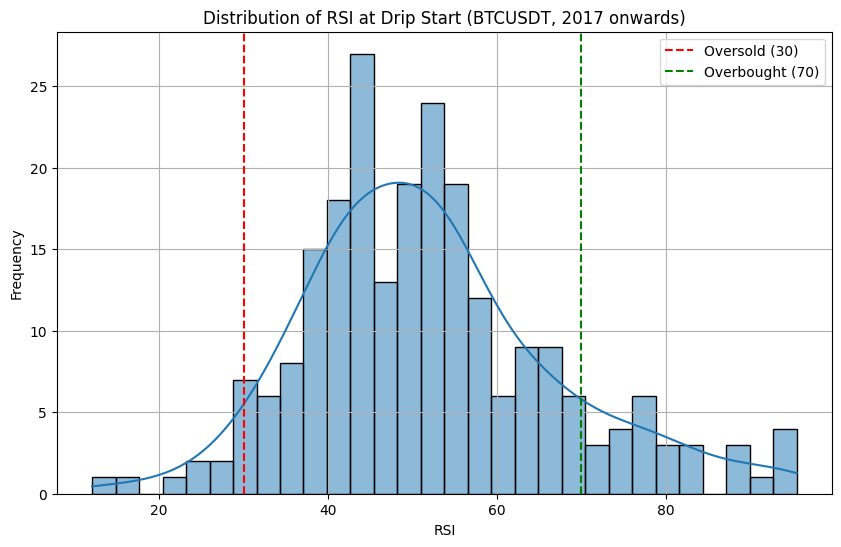

In [5]:
# สร้างฮิสโตแกรมของ RSI
plt.figure(figsize=(10, 6))
sns.histplot(drips['rsi_at_start'].dropna(), bins=30, kde=True)
plt.title('Distribution of RSI at Drip Start (BTCUSDT, 2017 onwards)')
plt.xlabel('RSI')
plt.ylabel('Frequency')
plt.axvline(30, color='r', linestyle='--', label='Oversold (30)')
plt.axvline(70, color='g', linestyle='--', label='Overbought (70)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# ทดสอบความปกติของ RSI (Shapiro-Wilk Test)
stat, p_value = stats.shapiro(drips['rsi_at_start'].dropna())
print(f"\nShapiro-Wilk Test for RSI Normality: stat={stat:.4f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("RSI distribution is not normal (p < 0.05)")
else:
    print("RSI distribution is normal (p >= 0.05)")


Shapiro-Wilk Test for RSI Normality: stat=0.9682, p-value=0.0000
RSI distribution is not normal (p < 0.05)


In [7]:
# 2. ค่าเฉลี่ย RSI ตามเดือน
monthly_rsi_means = drips.groupby('month')['rsi_at_start'].mean().reset_index()
monthly_rsi_means.columns = ['Month', 'Mean RSI']
print("\nMean RSI at Drip Start by Month:")
print(monthly_rsi_means.round(2))


Mean RSI at Drip Start by Month:
    Month  Mean RSI
0       1     48.40
1       2     54.85
2       3     54.83
3       4     48.01
4       5     46.35
5       6     51.70
6       7     57.67
7       8     44.66
8       9     49.58
9      10     67.26
10     11     54.21
11     12     53.44


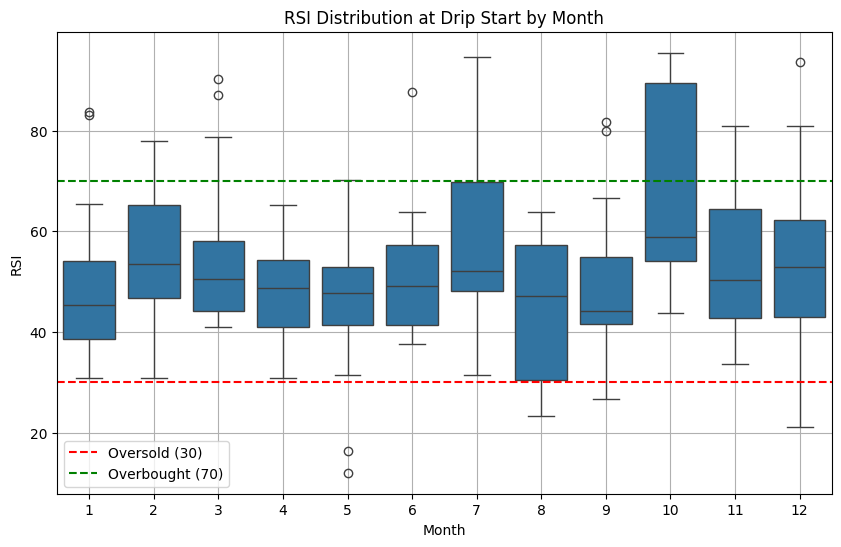

In [8]:
# สร้าง Boxplot เพื่อแสดงการกระจายของ RSI ตามเดือน
plt.figure(figsize=(10, 6))
sns.boxplot(x='month', y='rsi_at_start', data=drips)
plt.title('RSI Distribution at Drip Start by Month')
plt.xlabel('Month')
plt.ylabel('RSI')
plt.axhline(30, color='r', linestyle='--', label='Oversold (30)')
plt.axhline(70, color='g', linestyle='--', label='Overbought (70)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# 3. T-Test: เปรียบเทียบค่าเฉลี่ย RSI ระหว่างคู่เดือน
print("\nT-Test Results for RSI (p-values for pairwise comparisons):")
t_test_results = []
month_pairs = list(itertools.combinations(drips['month'].unique(), 2))
for month1, month2 in month_pairs:
    group1 = drips[drips['month'] == month1]['rsi_at_start'].dropna()
    group2 = drips[drips['month'] == month2]['rsi_at_start'].dropna()
    if len(group1) > 1 and len(group2) > 1:
        t_stat, p_value = stats.ttest_ind(group1, group2)
        t_test_results.append({
            'Month Pair': f'{month1} vs {month2}',
            'T-Statistic': t_stat,
            'P-Value': p_value
        })
t_test_df = pd.DataFrame(t_test_results)
print(t_test_df.round(4))


T-Test Results for RSI (p-values for pairwise comparisons):
   Month Pair  T-Statistic  P-Value
0      8 vs 9      -0.8868   0.3820
1     8 vs 10      -2.7716   0.0131
2     8 vs 11      -1.6029   0.1202
3     8 vs 12      -1.6376   0.1085
4      8 vs 1      -0.8041   0.4255
..        ...          ...      ...
61     4 vs 5       0.2870   0.7764
62     4 vs 7      -1.2363   0.2354
63     6 vs 5       1.0719   0.2918
64     6 vs 7      -0.8686   0.3949
65     5 vs 7      -1.7308   0.0949

[66 rows x 3 columns]


In [10]:
# 4. Tukey’s HSD Test: เปรียบเทียบค่าเฉลี่ย RSI ระหว่างทุกเดือน
if len(drips['month'].unique()) > 2:
    tukey = pairwise_tukeyhsd(endog=drips['rsi_at_start'].dropna(), groups=drips['month'], alpha=0.05)
    print("\nTukey’s HSD Test Results for RSI:")
    print(tukey.summary())
else:
    print("\nTukey’s HSD Test: Not enough months to perform the test.")


Tukey’s HSD Test Results for RSI:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2   6.4511 0.8934  -6.5672 19.4694  False
     1      3   6.4323 0.8861  -6.4073 19.2719  False
     1      4  -0.3811    1.0  -19.235 18.4728  False
     1      5  -2.0423    1.0 -15.4626  11.378  False
     1      6   3.3012 0.9999 -11.8714 18.4738  False
     1      7   9.2786  0.864  -8.6934 27.2506  False
     1      8  -3.7318 0.9999 -20.9659 13.5023  False
     1      9   1.1848    1.0 -11.6547 14.0244  False
     1     10    18.86 0.0304    0.888  36.832   True
     1     11   5.8104 0.9563  -7.6099 19.2307  False
     1     12   5.0404 0.9443  -6.2019 16.2827  False
     2      3  -0.0188    1.0  -14.439 14.4014  False
     2      4  -6.8322  0.993  -26.796 13.1317  False
     2      5  -8.4934 0.7714  -23.433  6.4462  False
     2      6  -3.1499    1.0 -19.6816 13.3817 